In [1]:
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# model definition

In [3]:
from residual_GAN import Discriminator

In [4]:
discriminator = Discriminator().to(device)

In [5]:
summary(discriminator,torch.zeros(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─LeakyReLU: 2-3                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-4                       [-1, 64, 64, 64]          200,704
|    └─BatchNorm2d: 2-5                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 64, 64]          --
├─Dropout2d: 1-2                         [-1, 64, 64, 64]          --
├─Sequential: 1-3                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-7                       [-1, 256, 64, 64]         16,384
|    └─BatchNorm2d: 2-8                  [-1, 256, 64, 64]         512
├─Sequential: 1-4                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-9                       [-1, 64, 64, 64]          4,0

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─LeakyReLU: 2-3                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-4                       [-1, 64, 64, 64]          200,704
|    └─BatchNorm2d: 2-5                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 64, 64]          --
├─Dropout2d: 1-2                         [-1, 64, 64, 64]          --
├─Sequential: 1-3                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-7                       [-1, 256, 64, 64]         16,384
|    └─BatchNorm2d: 2-8                  [-1, 256, 64, 64]         512
├─Sequential: 1-4                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-9                       [-1, 64, 64, 64]          4,0

# data pipeline

In [6]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

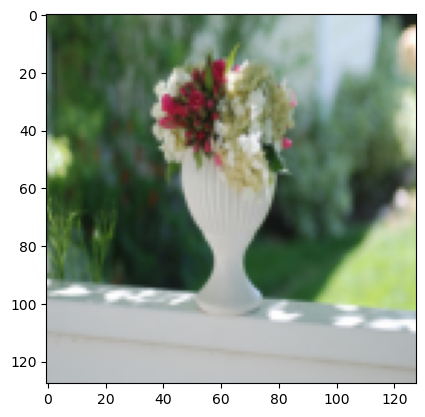

In [7]:
folder = "../../Datasets/annotated_img/images/train2017"
image_path = folder + "/000000000030.jpg"
image = Image.open(image_path).convert("RGB")
image = img_transforms(image)
plt.imshow(image.numpy().transpose(1,2,0))

In [8]:
from image_dataset import image_dataset


In [9]:
ds = image_dataset("../../Datasets/annotated_img/images/train2017",img_transforms)

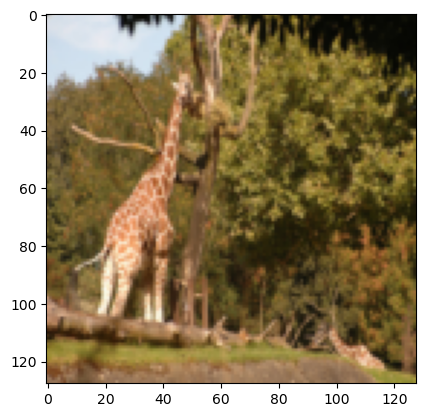

In [10]:
plt.imshow(ds[1].numpy().transpose(1,2,0))

In [11]:
from torch.utils.data import RandomSampler
num_samples = 12800
batch_size = 128
sampler = RandomSampler(ds,replacement=False,num_samples=num_samples)
dataloader = DataLoader(ds,batch_size=batch_size,sampler=sampler)

# generator

In [24]:
class Generator(torch.nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(noise_dim,256*4, kernel_size=10,padding=1),
            torch.nn.BatchNorm2d(256*4),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*4,256*4,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(256*4),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*4,256*2,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(256*2),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*2,256,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(128,64,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(64,64,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(64,32,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1, stride=1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
generator = Generator(noise_dim=2048)
generator.load_state_dict(torch.load("../text_to_image_generation/deep_200M/run3/generator_epoch60.pth"))

<All keys matched successfully>

In [23]:
os.listdir("../text_to_image_generation/deep_200M/run3")

['discriminator_epoch60.pth', 'doc.docx', 'generator_epoch60.pth']

# training routine

In [13]:
from torch_snippets import *

In [14]:
model_name = "residual_discriminator"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [15]:
def train_discriminator(discriminator,real_data,fake_data,loss_fn,optimizer):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real,torch.ones((len(real_data),1)).to(device))
    loss_real.backward()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.zeros((len(fake_data),1)).to(device))
    loss_fake.backward()
    optimizer.step()
    return loss_real, loss_fake

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-5)

In [17]:
def noise_generator(batch_size=64, dimension=2048):
    return torch.randn((batch_size,dimension)).to(device)

In [ ]:
generator.load_state_dict(torch.load("../text_to_image_generation/deep_200M/run3/generator_epoch60.pth"))

EPOCH: 1.000  loss_fake: 0.515  loss_real: 0.483  (107.64s - 107.64s remaining)
EPOCH: 2.000  loss_fake: 0.053  loss_real: 0.052  (219.50s - 0.00s remaining)))


100%|██████████| 103/103 [00:00<00:00, 17083.05it/s]


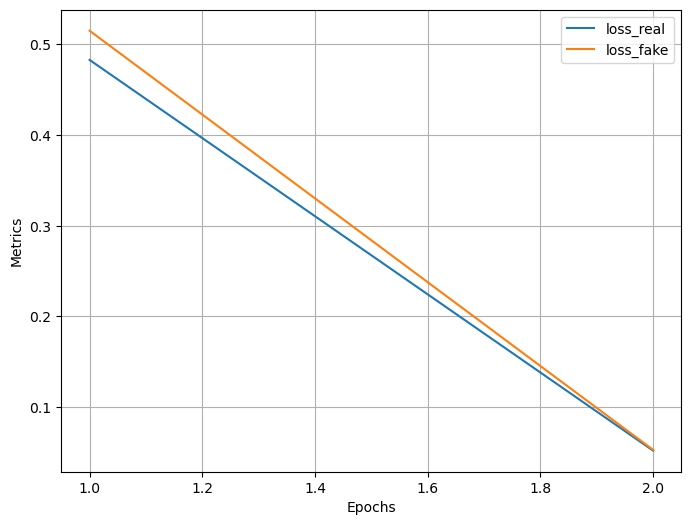

In [25]:
N = len(dataloader)
noise_dim=2048
num_epochs = 2
log = Report(num_epochs)
discriminator.to(device)
generator.to(device)
for epoch in range(num_epochs):
    for idx, imgs in enumerate(dataloader):
        real_data = imgs.to(device)
        fake_data = generator(noise_generator(batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        fake_data = fake_data.detach()
        d_loss_real, d_loss_fake = train_discriminator(discriminator,real_data,fake_data,loss_fn,optimizer)
        log.record(epoch+(1+idx)/N,loss_real=d_loss_real.item(), loss_fake=d_loss_fake.item(),end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['loss_real','loss_fake'])
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")

In [20]:
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")